# Parameter Estimation with $\mathcal{ERYN}$ for the LISA GW detector

This notebook demonstrates how we can perform parameter estimation (PE) for a **GB** (WDB) source with [Eryn](https://github.com/mikekatz04/Eryn). We will simulate the GW signal from a WDB using [GBGPU](https://github.com/mikekatz04/GBGPU) package and then, the light curve via `ellc` package. We will demonstrate a simple example of performing PE with a joint EM-GW likelihood.

More information:

- Eryn documentation [here](https://mikekatz04.github.io/Eryn/index.html).
- GBGPU documentation [here](https://mikekatz04.github.io/GBGPU/).
- Part of this notebook has been writen based on [this](https://github.com/asasli/hyperbolic_likelihood_filter) repo.

Please download the [data]() 📂 and save it in the same directory with the notebook!

> Notes: `conda activate -n acme_eryn_env` and install **GBGPU** for CPU-only version `pip install gbgpu`

----------------------------------------

Argyro Sasli $^\dagger$, Nikos Karnesis $^\ast$ 

$^\dagger$ University of Minnesota

$^\ast$ Aristotle University of Thessaloniki $\\$

(Nov 2025)

For the course of "ACME hands-on sessions" 

## A. Gravitational Waves

## Signal model

The galactic binary waveforms that we use depend on 8 parameters $\theta$:
* Amplitude `amp`
* Initial frequency `f0` (Hz)
* Initial time derivative of frequency `fdot` (Hz/s)
* Initial phase angle of gravitational wave `phi0` (radians)
* Inclination of the orbit `iota` (radians)
* Ecliptic longitude `lam` (radians)
* Ecliptic lattitude `beta` (radians)
* Polarization angle `psi` (radians)

The **GBGPU** package then gives us waveforms $h(\theta) = (A(\theta), E(\theta))$ where $A$, $E$ are TDI channels.

In [1]:
# Requirements
from gbgpu.gbgpu import GBGPU

# please uncomment if you have chainconsumer installed
#from chainconsumer import ChainConsumer
import corner

# useful modules for sampling etc
from eryn import ensemble
from eryn.ensemble import EnsembleSampler
from eryn.backends import HDFBackend
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.state import State
from eryn.utils import TransformContainer

import numpy as np
# make the plots look a bit nicer with some defaults
import matplotlib as mpl
import matplotlib.pyplot as plt
rcparams = {
    'axes.labelsize': 10,
    'font.size': 10,
    'text.latex.preamble': (r'\usepackage{revtex4-2}'),
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'text.usetex': False,
    'font.family': 'STIXGeneral',
    'mathtext.fontset': 'stix',
    'figure.dpi': 150,
    'figure.autolayout': True,
    'axes.linewidth': 0.5,
}
mpl.rcParams.update(rcparams) # update plot parameters

YRSID_SI = 31558149.763545603

signal length: (512,)


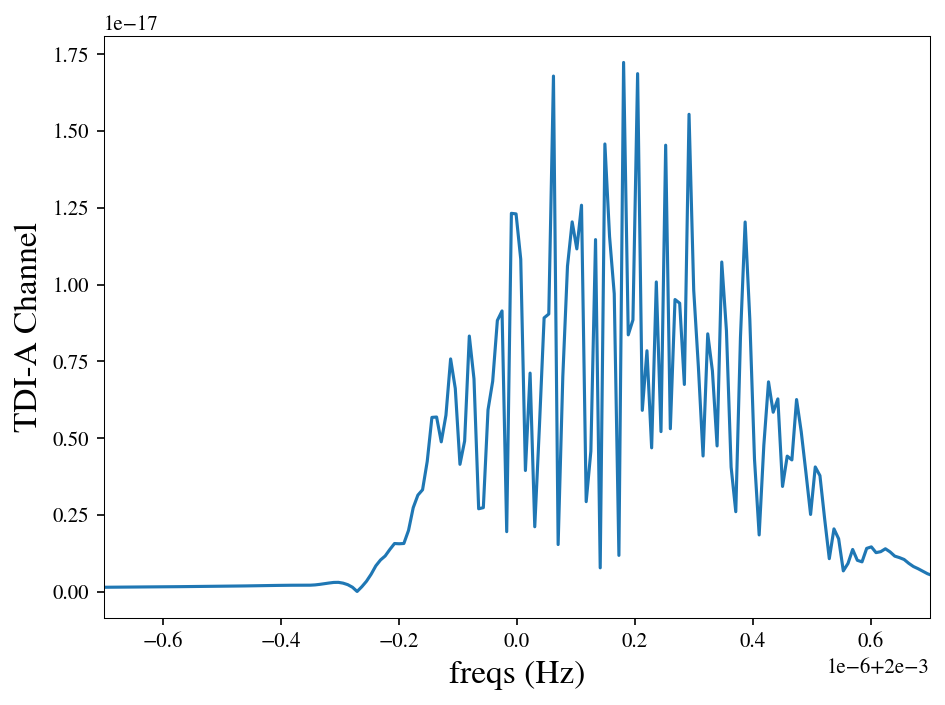

In [2]:
gb = GBGPU()

dt = 10.0
Tobs = 4.0 * YRSID_SI


# number of points in waveform
# if None, will determine inside the code based on amp, f0 (and P2 if running third-body waveform)
N = None

# parameters
amp = 2e-23  # amplitude
f0 = 2e-3  # f0
fdot = 10**-14.53675992  # fdot
fddot = 0.0 # fddot
phi0 = 0.1  # initial phase
iota = 0.2  # inclination
psi = 0.3  # polarization angle
lam = 0.4  # ecliptic longitude
beta_sky = 0.5  # ecliptic latitude

params = np.array(
    [amp, f0, fdot, fddot, phi0, iota, psi, lam, beta_sky,]
)

gb.run_wave(*params, N=N, dt=dt, T=Tobs, oversample=2)

# signal from first binary
A = gb.A[0]
freqs = gb.freqs[0]
print("signal length:", A.shape)

plt.plot(freqs, np.abs(A))
plt.ylabel("TDI-A Channel", fontsize=16)
plt.xlabel("freqs (Hz)", fontsize=16)
dx = 7e-7
plt.xlim(f0 - dx, f0 + dx);

We can write the waveform function and we will use it later for the PE.

In [3]:
class ucb:
    """
    Generating the waveform of a Ultra Compact Binary source and projecting it onto the LISA arms.
    Using the GBGPU package developed by M. Katz that can be found here: https://github.com/mikekatz04/GBGPU    
    """
    def __init__(self, f_lims=None, f_inds=None, tobs=1.0, dt=1.0):
        
        self._template = GBGPU()
        self._inds = f_inds 
        
        # N = get_N(1e-23, max(f_lims), tobs, oversample=2).item()
        self._waveform_kwargs = dict(N=f_inds[1]-f_inds[0], 
                                     dt=dt, 
                                     T=tobs)
        
        trans = {
            0: (lambda x: 10**(x)),
            1: (lambda x: x * 1e-3),
            2: (lambda x: 10**(x)),
            5: (lambda x: np.arccos(x)),
            8: (lambda x: np.arcsin(x)),}

        self._ndim_full = 9
        fill_dict = {3: 0.0}
        input_basis = list(range(len(trans)))       # [0,1,2,5,8]
        output_basis = list(range(self._ndim_full)) # 0..8

        self._transform_fn = TransformContainer(
            input_basis=input_basis,
            output_basis=output_basis,
            parameter_transforms=trans,
            fill_dict=fill_dict
        )

    def eval(self, params):
        """ Evaluating the model at a given parameter set.
        Args:
            params (ndarray): The parameter values to evaluate the likelihood on.
            ``params.shape=(num_params,)`` if 1D or
            ``params.shape=(num_params, num_binaries)`` if 2D for more than one binary.
            
        Returns:
            ndarray: A, E, T channels of the waveform. 
        """

        params = np.insert(params, 3, 0.0, axis=1) # inject with zeros for the fddot (we do not want to sample for it?)
        # Define the injection parameters                                            
        injct = self._transform_fn.transform_base_parameters(params, 
                        return_transpose=False).reshape(-1, self._ndim_full).T
        self._template.run_wave(*injct, **self._waveform_kwargs,) # inject into the template function
        A_temp, E_temp = self._template.A, self._template.E # Get the A and E channels
        
        return np.atleast_2d(A_temp), np.atleast_2d(E_temp), np.atleast_2d(injct) # We need 3 outputs for the likelihood

Let's test it!

In [4]:
rseed = 42
# WF parameters
log10A = -21.37729133
f0 = 2.61301 # In [mHz]
log10fdot = -16.53675992
phi0 = 3.12184095
cosi = 0.05407993
psi = 0.80372815
lamda = 1.76872
sinb = 0.1012303

t_obs = 1 # 1/12 # YRS
dt = 15 # The cadence, in seconds. Used to get the maximum frequency, also an input to the waveform
df = 1/(t_obs*YRSID_SI) # Get the frequency resolution

wf_parameter_names = [r"$\log_{10}\mathcal{A}$", r"$f_\mathrm{gw}~[\mathrm{mHz}]$", \
                      r"$\log_{10}\dot{f}_0$", r"$\phi_0$", r"$\cos\iota$", \
                      r"$\psi$", r"$\lambda$", r"$\sin\beta$"]

p0 = np.array([[log10A, f0, log10fdot, phi0, cosi, psi, lamda, sinb]])

# Get the default test-parameter values
print("\n > The default parameters are:\n")
print(" logA: {} \n   f0: {} \n fdot: {} \nfddot: {} \n phi0: {} \n \
  ci: {} \n  psi: {} \n  lam: {} \n   si: {}\n".format(*np.insert(p0, 3, 0.0, axis=1)[0,:]))

# Get the waveform settings
f0_lims = np.array([f0-1e-3, f0+1e-3]) * 1e-3

buffer = 200 # N-points as a buffer
fmin = f0_lims[0] - buffer * df
fmax = f0_lims[1] + buffer * df
start_freq_ind = int(fmin / df)
end_freq_ind = int(fmax / df)

fvec = np.arange(start_freq_ind, end_freq_ind + 1) * df # Our frequency vector

# Evaluate the model
template = ucb(f_lims=f0_lims, f_inds=[start_freq_ind, end_freq_ind + 1], \
                tobs=t_obs*YRSID_SI, dt=dt)
As, Es, _ = template.eval(p0)
# Ensure we have numpy arrays
As = np.array(As)
Es = np.array(Es)


 > The default parameters are:

 logA: -21.37729133 
   f0: 2.61301 
 fdot: -16.53675992 
fddot: 0.0 
 phi0: 3.12184095 
   ci: 0.05407993 
  psi: 0.80372815 
  lam: 1.76872 
   si: 0.1012303



Let's plot the signal!

Text(0, 0.5, 'TDI-A Channel')

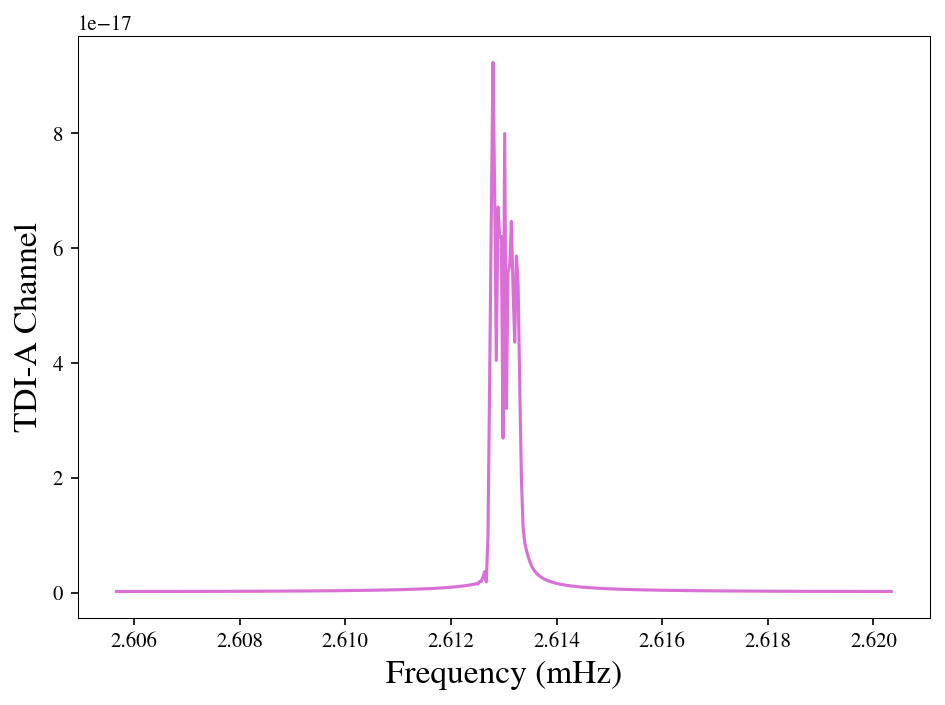

In [ ]:
plt.plot(fvec*1e+3, abs(As[0,:]), color='orchid')
plt.xlabel("Frequency (mHz)", fontsize=16)
plt.ylabel("TDI-A Channel", fontsize=16)

Let's load the provided data and see what we have there!

In [6]:
data = np.load("data_gbgpu.npz")

In [7]:
data.keys

<bound method NpzFile.keys of NpzFile 'data_gbgpu.npz' with keys: fvec, As, Es, Sn, waveform_parameters>

Text(0, 0.5, 'TDI Channels')

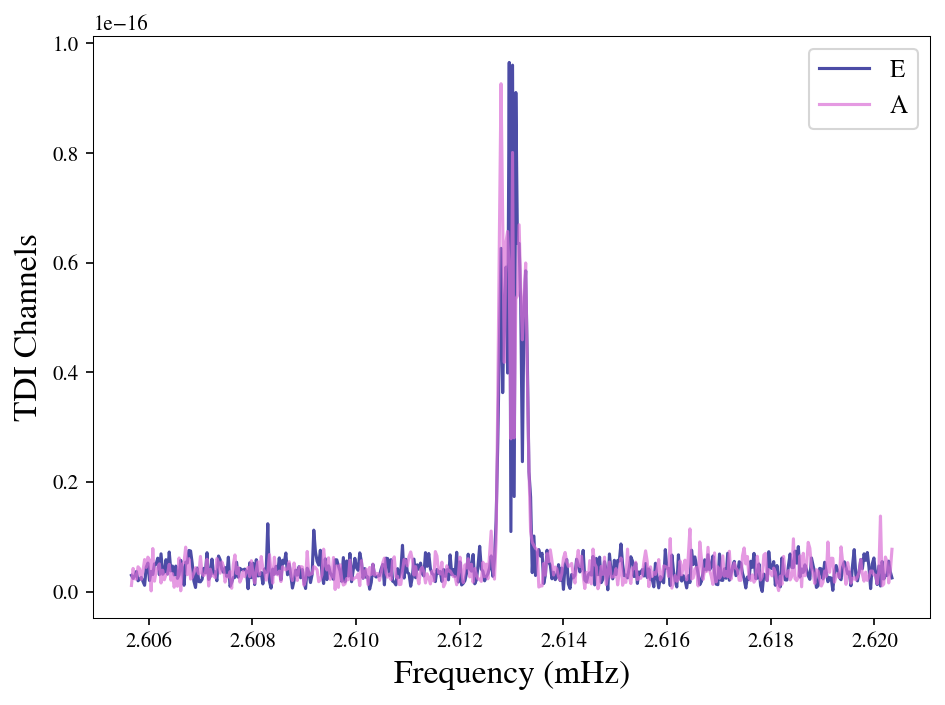

In [8]:
plt.plot(data['fvec']*1e+3, abs(data['Es']), color='navy', alpha=0.7, label='E')
plt.plot(data['fvec']*1e+3, abs(data['As']), color='orchid', alpha=0.7, label='A')
plt.legend(fontsize=12)
plt.xlabel("Frequency (mHz)", fontsize=16)
plt.ylabel("TDI Channels", fontsize=16)

We have the model, so now we need the likelihood function that we will provide to our sampler and perform the PE! Nikos has already provided the context of the Bayesian inference, so you know 😎

In Gravitational Wave astronomy, we begin by assuming that a measurement $y(t)$ is the sum of a signal $h$ that might depend on a parameter set $\vec{\theta}$ and a noise component as
$$y = h(\vec{\theta}) + n ,$$
where we have omitted the dependence on time $t$ for the sake of clarity. 

Then, assuming Gaussian properties of the noise, the likelihood of the measurement $y$ given a parameter set $\vec{\theta}$, takes the form of 
$$p(y|\vec{\theta})= C \times e^{ -\frac{1}{2}\langle y - h(\vec{\theta}) | y - h(\vec{\theta}) \rangle},$$
or 
$$\ln L \propto -\frac{1}{2} \langle y - h(\vec{\theta}) | y - h(\vec{\theta}) \rangle,$$
where the inner product uses the noise PSD.

In [ ]:
class likelihood:
    def __init__(self, data, template, f, df, Sn, infs=-1e300):
        self._A   = data[0]
        self._E   = data[1]
        self._Sn  = Sn        # The PSD of the noise: Assumed array or function
        self._df  = df
        self._f   = f
        self._template = template
        self._inf = infs

    # Utility function
    def _get_yy(self, theta):
        """ Utility function to get yy"""
        Af, Ef, _ = self._template.eval(theta)         
        res_A = (self._A - Af)
        res_E = (self._E - Ef)
        LA = 2. * self._df * (res_A.conj() * res_A)
        LE = 2. * self._df * (res_E.conj() * res_E)
        return (LA + LE)

    # log-likelihood
    def eval(self, theta):
        """ Gaussian log-likelihood:
        """
        L = - .5 * np.sum( self._get_yy(theta) / self._Sn, axis=-1).real
        L = np.nan_to_num(L, copy=True, nan=self._inf, posinf=self._inf, neginf=self._inf)
        return L

In [10]:
Lh = likelihood( data=(data['As'], data['Es']), 
                 template=template, 
                 f=data['fvec'], 
                 df=df, 
                 Sn=data['Sn'] )

In [11]:
Lh.eval(p0)

array([-476.10301764])

Let's start initializing the parameters for $\mathcal{Eryn}$

In [ ]:
logL = Lh.eval 
# Mark the true parameters
truth_params = list(p0[0,:])

# Set the parameter names
parameter_names = wf_parameter_names

# Setup priors for WF parameters -> names :[log10A, f0, log10fdot, phi0, cosi, psi, lamda, sinb]
cmin = np.array([-30, .1*f0,  -20., 0.,      -1, 0.0,    0.,     -1])
cmax = np.array([-19, 2.0*f0, -10., 2*np.pi, 1., np.pi,  2*np.pi, 1])

ndims = p0.shape[1]

priors_in = {i: uniform_dist(cmin[i], cmax[i]) for i in range(ndims)}
priors = ProbDistContainer(priors_in)

# Set the periodic parameters
# Remember: [log10A, f0, log10fdot, phi0, cosi, psi, lamda, sinb]
periodic = {"model_0": {3: 2 * np.pi, 5: np.pi, 6: 2 * np.pi}}

ntemps, nwalkers, nsteps, burnin = 5, 20, 10000, 5000

Just for this example, because we need some fast convergence, we will generate the starting points around the true values

In [13]:
# starting positions 
epsilon = np.array([1, 0.1*f0, 1, 0.1, 0.1, 0.1, 0.1, 0.1])
starting_vals = p0[0] + np.random.randn(ntemps*nwalkers, ndims) * epsilon
# just making sure they are within the prior
starting_vals = np.clip(starting_vals, cmin, cmax)
starting_vals = starting_vals.reshape(ntemps, nwalkers, ndims)

coords = np.zeros((ntemps, nwalkers, 1, ndims)) # Define the starting coordinates
coords[:, :, 0, :] = starting_vals.copy()

Now, let's make sure that these values work with our likelihood!

In [14]:
# Evaluate at the initial values
log_l = logL(coords[:, :, 0, :].reshape(ntemps*nwalkers, ndims))

# Define the initial state, plus the H5 file to save the data to.
state = State(coords, log_like=log_l.reshape(ntemps, nwalkers)) # blobs=blobs
betas = np.linspace(1.0, 0.0, ntemps)
backend = HDFBackend("GB_test_mcmc_chains.h5")

# Define the Ensemble sampler
ensemble = EnsembleSampler(
        nwalkers,
        ndims,
        logL,
        priors,
        args=(),
        vectorize=True,
        tempering_kwargs=dict(betas=betas, stop_adaptation=burnin),
        plot_iterations=-1,
        periodic=periodic,
        update_iterations=1,
        backend=backend,
    )

In [15]:
print(" > Sampling starting ...")

ensemble.run_mcmc(state, int(nsteps), burn=burnin, progress=True, thin_by=1)


 > Sampling starting ...


100%|██████████| 10000/10000 [05:31<00:00, 30.17it/s]


In [16]:
def get_clean_chain(coords, ndim, temp=0):
    """Simple utility function to extract the squeezed chains for all the parameters
    """
    naninds    = np.logical_not(np.isnan(coords[:, temp, :, :, 0].flatten()))
    samples_in = np.zeros((coords[:, temp, :, :, 0].flatten()[naninds].shape[0], ndim))  # init the chains to plot
    # get the samples to plot
    for d in range(ndim):
        givenparam = coords[:, temp, :, :, d].flatten()
        samples_in[:, d] = givenparam[
            np.logical_not(np.isnan(givenparam))
        ]  # Discard the NaNs, each time they change the shape of the samples_in
    return samples_in

In [17]:
samples = get_clean_chain(ensemble.get_chain()['model_0'], ndims)

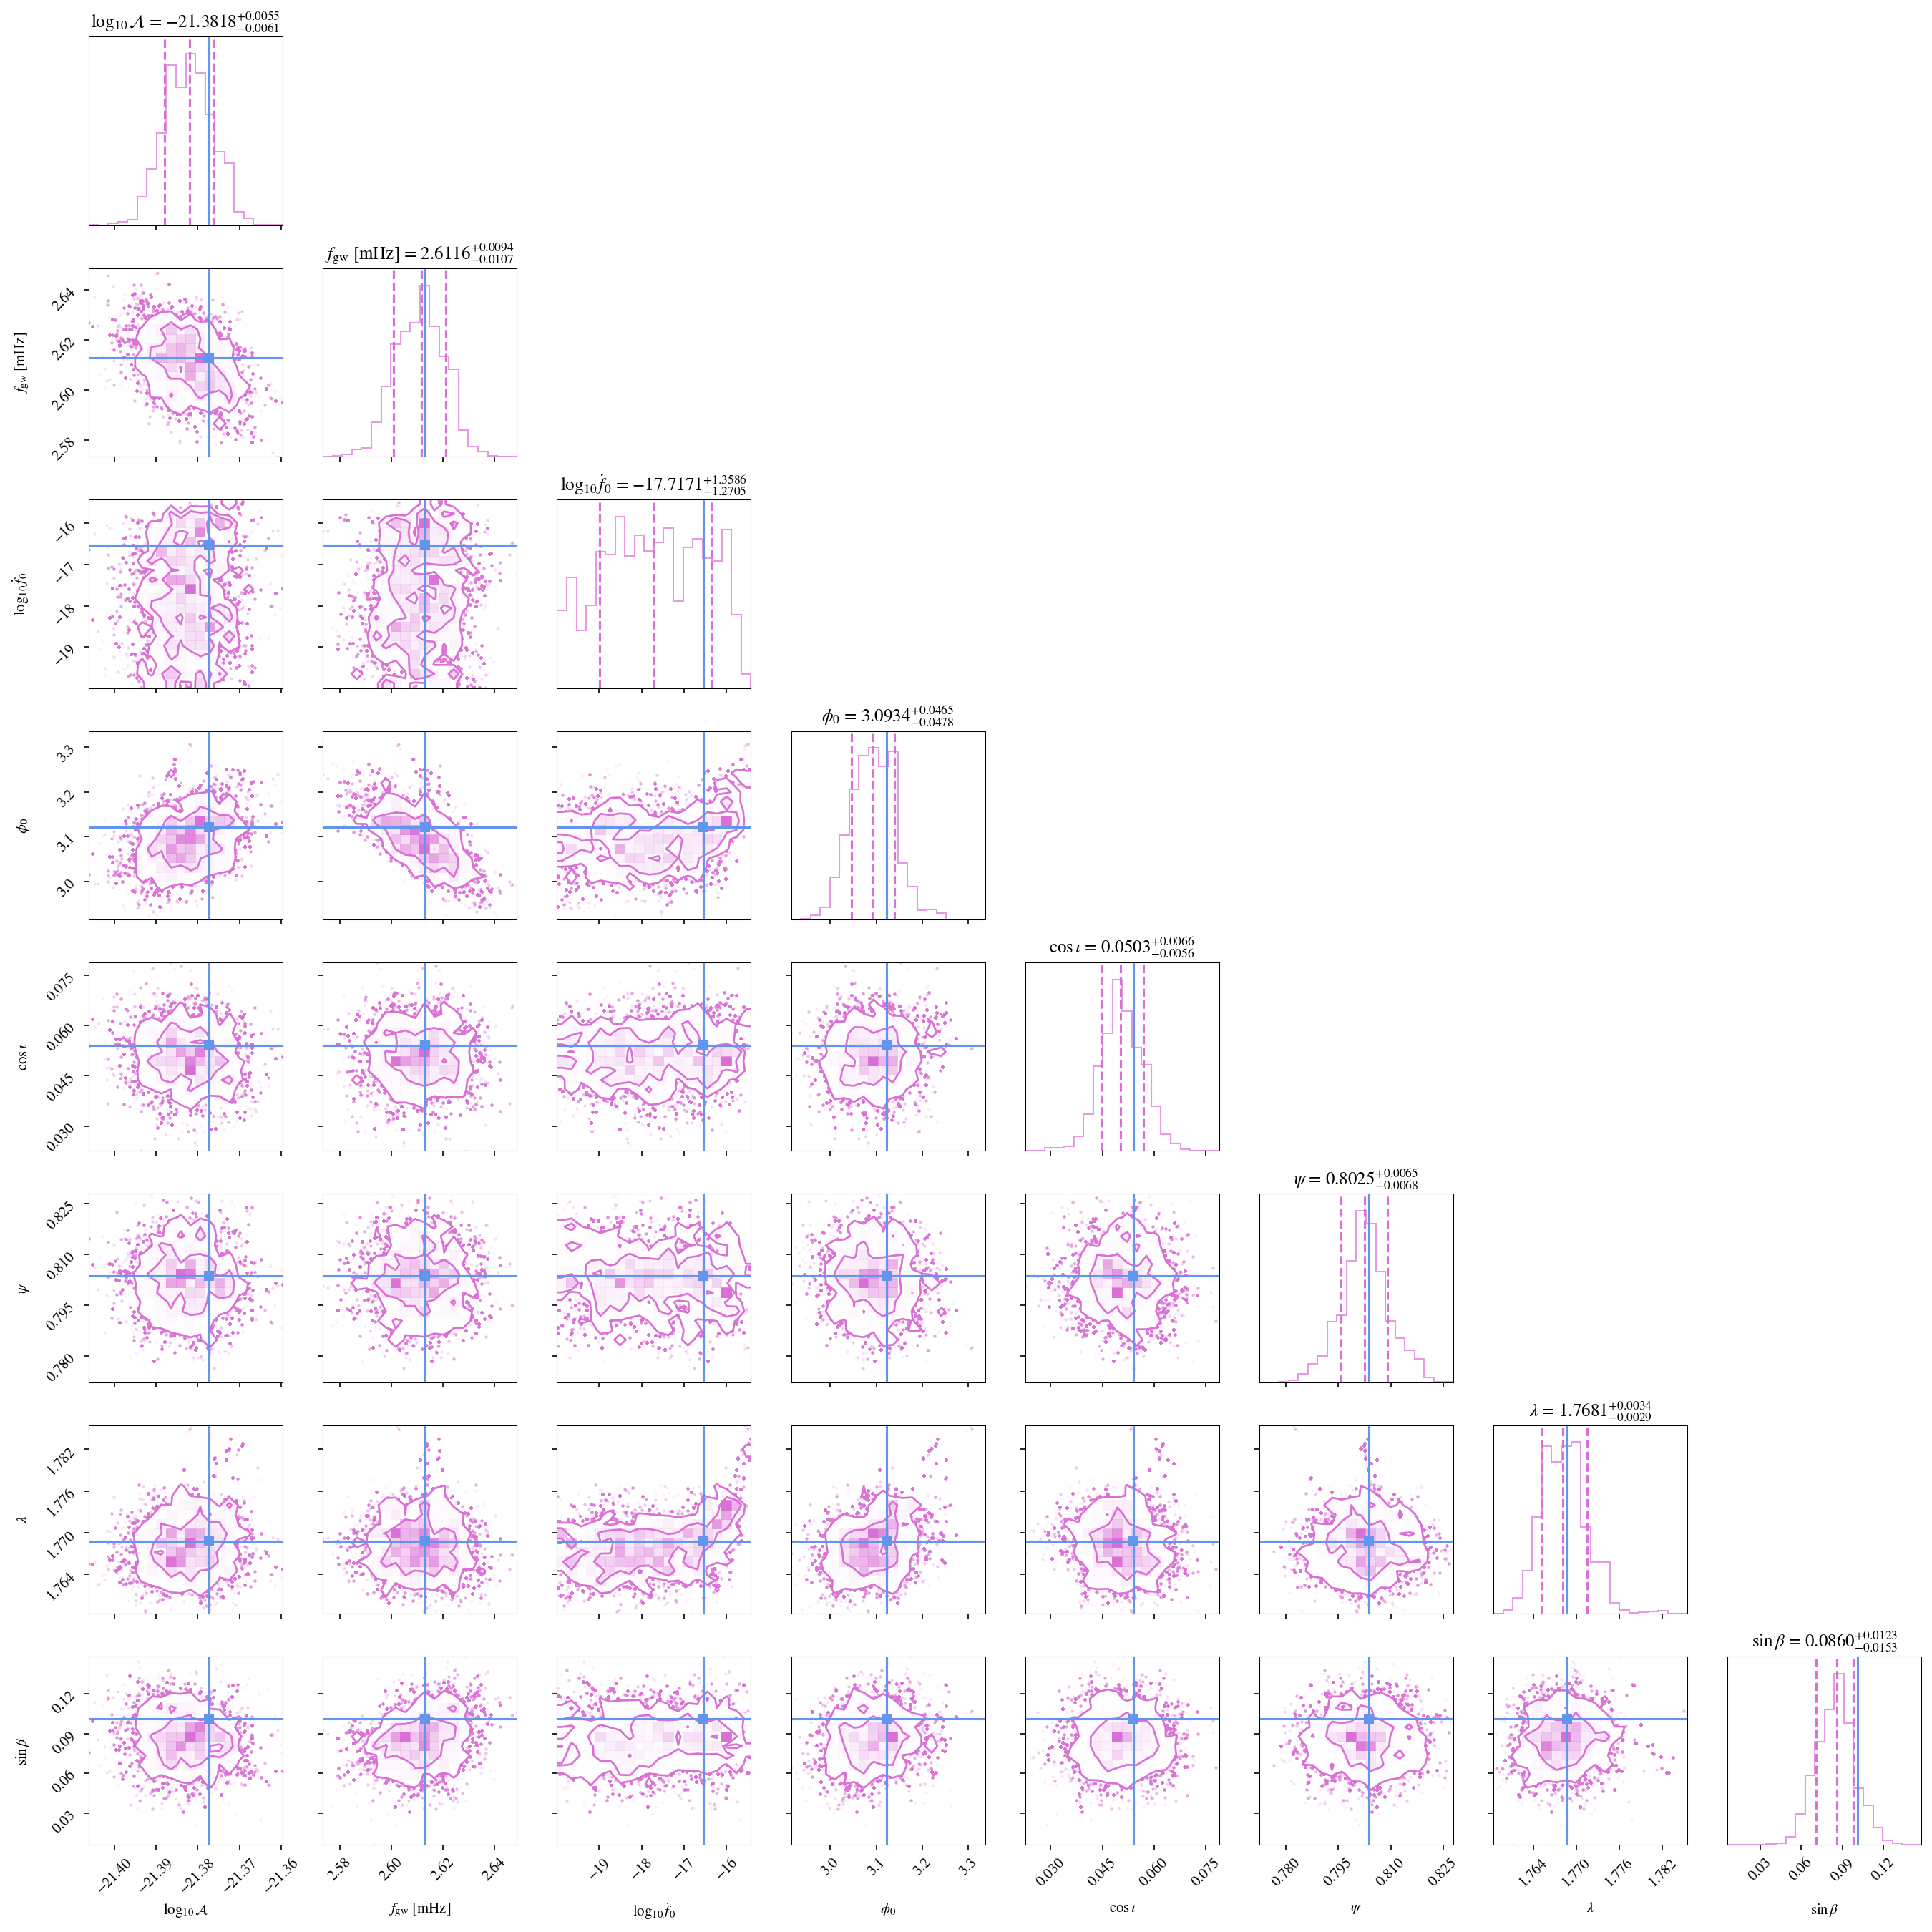

In [18]:
figure = corner.corner(
    samples,
    labels=parameter_names,
    truths=truth_params,
    show_titles=True,
    title_fmt=".4f",
    title_kwargs={"fontsize": 12},
    quantiles=[0.16, 0.5, 0.84],
    levels=(0.68, 0.95),
    color="orchid",
    truth_color="cornflowerblue",
    hist_kwargs={"density": True, "alpha": 0.7},
    contour_kwargs={"linewidths": 1.3},
    truth_kwargs={"linewidth": 2},
)


## B. EM component: Light-curves

For this part of the notebook, we are going to use `ellc` package for simulating **optical light curves** of **white dwarf binaries**.

In [ ]:
from pathlib import Path
import sys, subprocess

# Try importing ellc; if missing, install and import.
try:
    import ellc
except Exception:
    try:
        get_ipython  # type: ignore[name-defined]
        %pip install ellc
    except Exception:
        # Fallback for non-notebook environments
        subprocess.check_call([sys.executable, "-m", "pip", "install", "ellc"])
    import ellc

G = 6.67430e-11
c = 299792458.0
Msun = 1.98847e30
Rsun = 6.957e8

print("ellc imported, version:", getattr(ellc, "__version__", "unknown"))

ellc imported, version: 1.8.10


### Fractional Radii
`ellc` expects **radii in units of the semi-major axis**:

$$r_1 = R_1 / a, \quad r_2 = R_2 / a.$$

The semi-major axis is computed using Kepler's third law:

$$a = \left(G(M_1 + M_2) \left(\frac{P}{2\pi}\right)^2 \right)^{1/3}.$$

### Limb Darkening
`ellc` supports:
- `'lin'` (linear)
- `'quad'` (quadratic)
- `'claret'` (4-parameter)

For white dwarfs, a linear model is usually fine for exploratory simulations.

### Ellipsoidal Variation
If you set `shape='roche'`, the stars are tidally distorted. This produces variability at **2 × orbital frequency**.

### Doppler Beaming
Flux changes due to relativistic beaming:

$$A_{beam} ≈ (K / c)(3 − \alpha).$$

In `ellc`, this is controlled using `f_c` and `f_s`. You must give *both or neither*.

### Reflection / Heating
Set with `heat_1`, `heat_2`.

### Eclipses
`ellc` computes them automatically depending on inclination and radii.

Let's define our parameters for the simulation!
>Note: We should take into account the parameters from the above section.

In [20]:
h0 = 10**log10A
f_gw = f0 * 1e-3     # Hz
fdot = 10**log10fdot     # Hz/s
inc_deg = np.degrees(np.arccos(cosi))

# compute chirp mass from fdot (leading order)
pi = np.pi
factor = (5.0/96.0) * (c**5) / ( (pi**(8.0/3.0)) * (G**(5.0/3.0)) )
Mc_53 = fdot * factor * f_gw**(-11.0/3.0)
Mc = Mc_53**(3.0/5.0)

# choose mass ratio q (example)
q = 0.5
# get M1,M2 from Mc and q:
M1 = Mc * (1+q)**(1.0/5.0) / (q**(3.0/5.0))
M2 = q * M1

# orbital period
f_orb = f_gw / 2.0
P = 1.0 / f_orb   # seconds

# semi-major axis
a = (G*(M1+M2)*(P/(2*np.pi))**2)**(1/3)

# estimate WD radii (Nauenberg T=0 approximation)
Mch = 1.44 * Msun
def R_wd(M):
    term = (Mch/M)**(2.0/3.0) - (M/Mch)**(2.0/3.0)
    if term <= 0:
        return 0.01 * Rsun
    return 0.0112 * Rsun * np.sqrt(term)

R1 = R_wd(M1)
R2 = R_wd(M2)

# fractional radii for ellc
radius_1 = R1 / a
radius_2 = R2 / a

# mass ratio input for ellc
q_input = M2 / M1

# Doppler beaming estimate
inc_rad = np.deg2rad(inc_deg)
K1 = (2*np.pi*a / P) * (M2/(M1+M2)) * np.sin(inc_rad)
alpha = 1.0
A_beam = (K1 / c) * (3.0 - alpha)

# ellc inputs
ellc_params = {
    't_obs_days': None,        # you will supply time array converted to days
    'radius_1': radius_1,
    'radius_2': radius_2,
    'sbratio': 1.0,
    'incl': inc_deg,
    'period_days': P/86400.0,
    'q': q_input,
    'ld_1': 'lin',
    'ldc_1': [0.3],
    'ld_2': 'lin',
    'ldc_2': [0.3],
    'shape_1': 'roche',
    'shape_2': 'roche',
    'f_c': A_beam,   # or scale if you prefer
    'f_s': 0.0,
    'heat_1': 0.0,
    'heat_2': 0.0
}
# Reminder: t_obs is the years of observation
yr_s = 365.25 * 24*3600
t_seconds = np.arange(0, t_obs*yr_s, 15)   # dt = 15 s
t_days = t_seconds / 86400.0

# simulate light curve
flux = ellc.lc(
    t_obs=t_days,
    radius_1=ellc_params['radius_1'],
    radius_2=ellc_params['radius_2'],
    sbratio=ellc_params['sbratio'],
    incl=ellc_params['incl'],
    t_zero=0.0,
    period=ellc_params['period_days'],
    q=ellc_params['q'],
    ld_1=ellc_params['ld_1'], ldc_1=ellc_params['ldc_1'],
    ld_2=ellc_params['ld_2'], ldc_2=ellc_params['ldc_2'],
    shape_1=ellc_params['shape_1'], shape_2=ellc_params['shape_2'],
    f_c=ellc_params['f_c'], f_s=ellc_params['f_s'],
    heat_1=ellc_params['heat_1'], heat_2=ellc_params['heat_2'],
    grid_1='default', grid_2='default'
)


Text(0, 0.5, 'Flux')

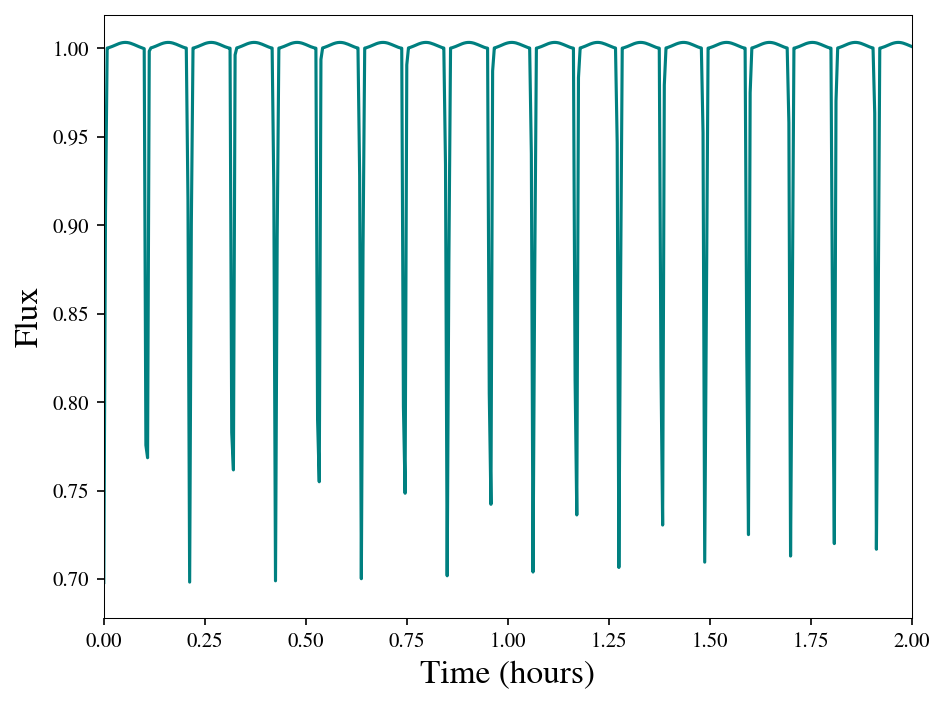

In [21]:
plt.plot(t_seconds/3600.0, flux, color='teal')
plt.xlim(0, 2)
plt.xlabel("Time (hours)", fontsize=16)
plt.ylabel("Flux", fontsize=16)

In [22]:
# Create data only for 15 days; just to make it faster
t_days_for_run = np.linspace(0, 15, 200)
flux = ellc.lc(
    t_obs= t_days_for_run,   # 15 days, 200 points,
    radius_1=ellc_params['radius_1'],
    radius_2=ellc_params['radius_2'],
    sbratio=ellc_params['sbratio'],
    incl=ellc_params['incl'],
    t_zero=0.0,
    period=ellc_params['period_days'],
    q=ellc_params['q'],
    ld_1=ellc_params['ld_1'], ldc_1=ellc_params['ldc_1'],
    ld_2=ellc_params['ld_2'], ldc_2=ellc_params['ldc_2'],
    shape_1=ellc_params['shape_1'], shape_2=ellc_params['shape_2'],
    f_c=ellc_params['f_c'], f_s=ellc_params['f_s'],
    heat_1=ellc_params['heat_1'], heat_2=ellc_params['heat_2'],
    grid_1='default', grid_2='default'
)


In [ ]:
# Let's add some noise
# In realistic cases, you would have measurement uncertainties from the data
uncertainty = 1e-3
flux_err = np.maximum(uncertainty * np.abs(flux), 1e-12)

Let's create our functions for the light-curve template!

In [31]:
def template_model_flux_single(q_val, incl_deg):
    return ellc.lc(
        t_obs=t_days_for_run,
        radius_1=ellc_params['radius_1'],
        radius_2=ellc_params['radius_2'],
        sbratio=ellc_params['sbratio'],
        incl=incl_deg,
        t_zero=0.0,
        period=ellc_params['period_days'],
        q=q_val,
        ld_1=ellc_params['ld_1'], ldc_1=ellc_params['ldc_1'],
        ld_2=ellc_params['ld_2'], ldc_2=ellc_params['ldc_2'],
        shape_1=ellc_params['shape_1'], shape_2=ellc_params['shape_2'],
        f_c=ellc_params['f_c'], f_s=ellc_params['f_s'],
        heat_1=ellc_params['heat_1'], heat_2=ellc_params['heat_2'],
        grid_1='default', grid_2='default'
    )

# "vectorized" version
def template_model_flux(theta):
    # allow theta to be provided as 1D or 2D
    theta = np.atleast_2d(theta)
    n = theta.shape[0]
    Nt = t_days_for_run.size
    out = np.zeros((n, Nt))

    for i in range(n):
        q_val = theta[i, 0]
        incl = theta[i, 1]
        out[i] = template_model_flux_single(q_val, incl)
    return out

def em_logL(theta):
    model_flux = template_model_flux(theta)   # shape = [nwalkers, Nt]
    sigma = flux_err
    ll = np.zeros(theta.shape[0])

    for i in range(theta.shape[0]):
        resid = flux - model_flux[i]
        ll[i] = -0.5 * np.sum((resid/sigma)**2 + np.log(2*np.pi*sigma**2))

    # numerical safety
    ll = np.nan_to_num(ll, copy=True, nan=-1e300, posinf=-1e300, neginf=-1e300)
    return ll

Setup Eryn for PE

In [ ]:
# Quick setup
q_min, q_max = 0.1, 1.0
inc_min, inc_max = 0.0, 90.0
priors_in = {0: uniform_dist(q_min, q_max), 1: uniform_dist(inc_min, inc_max)}
priors = ProbDistContainer(priors_in)

ndims = 2
ntemps = 3
nwalkers = 5
nsteps = 800
burnin = 200

# starting positions
true_q = ellc_params['q']
true_inc = ellc_params['incl']
epsilon = np.array([0.02, 1.0])
start = np.array([true_q, true_inc])
starting_vals = start + np.random.randn(ntemps * nwalkers, ndims) * epsilon
starting_vals = np.clip(starting_vals, [q_min, inc_min], [q_max, inc_max])
starting_vals = starting_vals.reshape(ntemps, nwalkers, ndims)
coords = np.zeros((ntemps, nwalkers, 1, ndims))
coords[:, :, 0, :] = starting_vals.copy()

# initial log-likelihood evaluation
log_l = em_logL(coords[:, :, 0, :].reshape(ntemps * nwalkers, ndims))
state = State(coords, log_like=log_l.reshape(ntemps, nwalkers))

In [ ]:
backend = HDFBackend("em_lightcurve_chains_q_incl.h5")
betas_local = np.linspace(1.0, 0.0, ntemps)

# Define the Ensemble sampler
ensemble = EnsembleSampler(
        nwalkers,
        ndims,
        em_logL,
        priors,
        args=(),
        vectorize=True,
        tempering_kwargs=dict(betas=betas_local, stop_adaptation=burnin),
        plot_iterations=-1,
        update_iterations=1,
        backend=backend,
    )

print(" > Sampling starting ...")

ensemble.run_mcmc(state, int(nsteps), burn=burnin, progress=True, thin_by=1)

 > Sampling starting ...


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 800/800 [00:51<00:00, 15.49it/s]


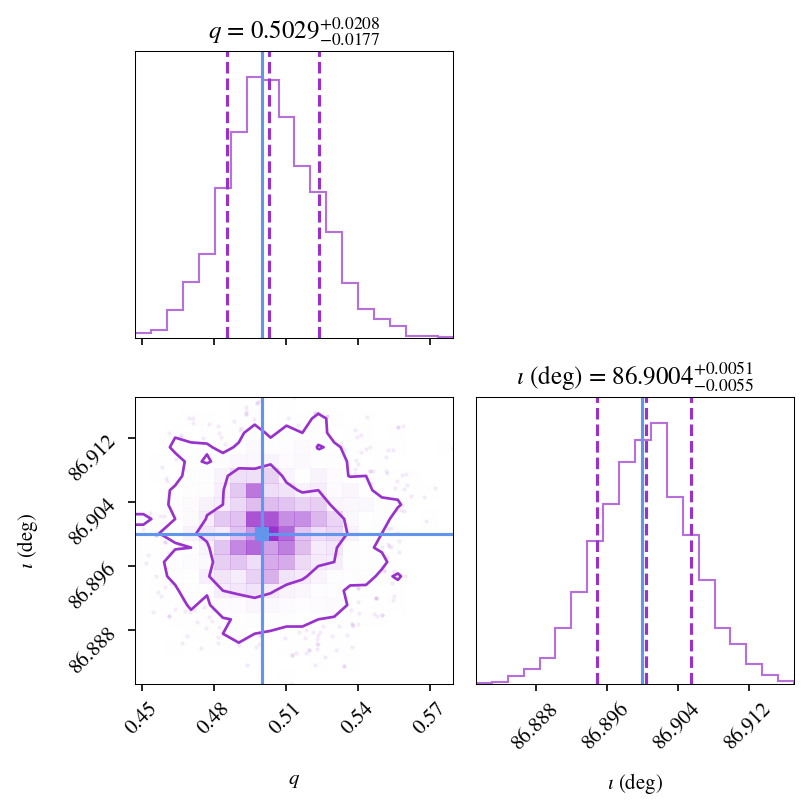

In [35]:
samples = get_clean_chain(ensemble.get_chain()['model_0'], ndims)

figure = corner.corner(
    samples,
    labels=['$q$', r'$\iota$ (deg)'],
    truths=[true_q, true_inc],
    show_titles=True,
    title_fmt=".4f",
    title_kwargs={"fontsize": 12},
    quantiles=[0.16, 0.5, 0.84],
    levels=(0.68, 0.95),
    color="darkorchid",
    truth_color="cornflowerblue",
    hist_kwargs={"density": True, "alpha": 0.7},
    contour_kwargs={"linewidths": 1.3},
    truth_kwargs={"linewidth": 2},
)


## C. Joint EM-GW PE

We define a **joint likelihood** for two independent datasets:

1. **EM dataset** (e.g., light curve)
2. **GW dataset** (gravitational wave signal)

For this example, the datasets share **one common parameter** (e.g., inclination `incl`), while each has additional parameters unique to itself.  

Let:

- $D_{\rm EM}$ = EM dataset  
- $D_{\rm GW}$ = GW dataset  
- $\theta_{\rm EM}$ = parameters relevant to EM (including the common parameter)  
- $\theta_{\rm GW}$ = parameters relevant to GW (including the common parameter)  

Assuming the datasets are independent, the **joint likelihood** is:

$$\mathcal{L}_{\rm joint}(\theta) = \mathcal{L}_{\rm EM}(\theta_{\rm EM}) \times \mathcal{L}_{\rm GW}(\theta_{\rm GW})$$

or, equivalently in log-space:

$$\log \mathcal{L}_{\rm joint}(\theta) = \log \mathcal{L}_{\rm EM}(\theta_{\rm EM}) + \log \mathcal{L}_{\rm GW}(\theta_{\rm GW})$$

> **Note:** Parameters that appear only in one dataset (“private” parameters) do **not** contribute to the likelihood of the other dataset. Only the common parameters affect both likelihoods.

In [57]:
# SAME WITH SECTION B -- just making sure that everything is correct :)

# Create data only for 15 days; just to make it faster
t_days_for_run = np.linspace(0, 15, 200)
flux = ellc.lc(
    t_obs= t_days_for_run,   # 15 days, 200 points,
    radius_1=ellc_params['radius_1'],
    radius_2=ellc_params['radius_2'],
    sbratio=ellc_params['sbratio'],
    incl=ellc_params['incl'],
    t_zero=0.0,
    period=ellc_params['period_days'],
    q=ellc_params['q'],
    ld_1=ellc_params['ld_1'], ldc_1=ellc_params['ldc_1'],
    ld_2=ellc_params['ld_2'], ldc_2=ellc_params['ldc_2'],
    shape_1=ellc_params['shape_1'], shape_2=ellc_params['shape_2'],
    f_c=ellc_params['f_c'], f_s=ellc_params['f_s'],
    heat_1=ellc_params['heat_1'], heat_2=ellc_params['heat_2'],
    grid_1='default', grid_2='default'
)
# Let's add some noise
# In realistic cases, you would have measurement uncertainties from the data
uncertainty = 1e-3
flux_err = np.maximum(uncertainty * np.abs(flux), 1e-12)

We are going to simplify more the problem, meaning that we will use only 1 parameter (inclination) for the em part.

In [75]:
def template_model_flux_single(incl_deg):
    return ellc.lc(
        t_obs=t_days_for_run,
        radius_1=ellc_params['radius_1'],
        radius_2=ellc_params['radius_2'],
        sbratio=ellc_params['sbratio'],
        incl=incl_deg,
        t_zero=0.0,
        period=ellc_params['period_days'],
        q=ellc_params['q'],
        ld_1=ellc_params['ld_1'], ldc_1=ellc_params['ldc_1'],
        ld_2=ellc_params['ld_2'], ldc_2=ellc_params['ldc_2'],
        shape_1=ellc_params['shape_1'], shape_2=ellc_params['shape_2'],
        f_c=ellc_params['f_c'], f_s=ellc_params['f_s'],
        heat_1=ellc_params['heat_1'], heat_2=ellc_params['heat_2'],
        grid_1='default', grid_2='default'
    )
    
# "vectorized" version
def template_model_flux(theta):
    theta = np.atleast_1d(theta)
    n = theta.size
    Nt = t_days_for_run.size
    out = np.zeros((n, Nt))
    
    for i in range(n):
        incl = theta[i]  # just 1 for this example
        out[i] = template_model_flux_single(incl)
    return out

def em_logL(theta):
    model_flux = template_model_flux(theta)   # shape = [nwalkers, Nt]
    sigma = flux_err
    ll = np.zeros(theta.shape[0])

    for i in range(theta.shape[0]):
        resid = flux - model_flux[i]
        ll[i] = -0.5 * np.sum((resid/sigma)**2 + np.log(2*np.pi*sigma**2))

    # numerical safety
    ll = np.nan_to_num(ll, copy=True, nan=-1e300, posinf=-1e300, neginf=-1e300)
    return ll

We are going to implement the joint likelihood

In [77]:
def joint_logL(theta):
    """
    theta: parameters (same ordering with A section)
    """
    inc_deg = np.degrees(np.arccos(theta[:,4]))
    ll_flux = em_logL(inc_deg)
    ll_gw   = logL(theta)

    # ensure same shapes
    ll_flux = np.atleast_1d(ll_flux)
    ll_gw   = np.atleast_1d(ll_gw)

    return ll_flux + ll_gw

Let's setup again Eryn -- Same with A section

In [ ]:
# Mark the true parameters
truth_params = list(p0[0,:])

# Set the parameter names
parameter_names = wf_parameter_names

# Setup priors for WF parameters -> names :[log10A, f0, log10fdot, phi0, cosi, psi, lamda, sinb]
cmin = np.array([-30, .1*f0,  -20., 0.,      -1, 0.0,    0.,     -1])
cmax = np.array([-19, 2.0*f0, -10., 2*np.pi, 1., np.pi,  2*np.pi, 1])

ndims = p0.shape[1]

priors_in = {i: uniform_dist(cmin[i], cmax[i]) for i in range(ndims)}
priors = ProbDistContainer(priors_in)

# Set the periodic parameters [log10A, f0, log10fdot, phi0, cosi, psi, lamda, sinb]
periodic = {"model_0": {3: 2 * np.pi, 5: np.pi, 6: 2 * np.pi}}

ntemps, nwalkers, nsteps, burnin = 5, 20, 10000, 5000

# starting positions 
epsilon = np.array([1, 0.1*f0, 1, 0.1, 0.1, 0.1, 0.1, 0.1])
starting_vals = p0[0] + np.random.randn(ntemps*nwalkers, ndims) * epsilon
# just making sure they are within the prior
starting_vals = np.clip(starting_vals, cmin, cmax)
starting_vals = starting_vals.reshape(ntemps, nwalkers, ndims)

coords = np.zeros((ntemps, nwalkers, 1, ndims)) # Define the starting coordinates
coords[:, :, 0, :] = starting_vals.copy()


# Evaluate at the initial values
log_l = joint_logL(coords[:, :, 0, :].reshape(ntemps*nwalkers, ndims))

# Define the initial state, plus the H5 file to save the data to.
state = State(coords, log_like=log_l.reshape(ntemps, nwalkers)) # blobs=blobs
betas = np.linspace(1.0, 0.0, ntemps)
backend = HDFBackend("EMGW_joint_mcmc_chains.h5")

# Define the Ensemble sampler
ensemble = EnsembleSampler(
        nwalkers,
        ndims,
        joint_logL,
        priors,
        args=(),
        vectorize=True,
        tempering_kwargs=dict(betas=betas, stop_adaptation=burnin),
        plot_iterations=-1,
        periodic=periodic,
        update_iterations=1,
        backend=backend,
    )

print(" > Sampling starting ...")

ensemble.run_mcmc(state, int(nsteps), burn=burnin, progress=True, thin_by=1)



 > Sampling starting ...


 61%|██████    | 3048/5000 [21:40<13:32,  2.40it/s]

# $\mathcal{fin}$